In [1]:
import numpy as np
import uproot
from scipy import interpolate
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

In [2]:
def GetFVCut(tree):
    cut = np.where((tree['passed_xy_thresh'].array() == True) \
               & (tree['passed_z_thresh'].array() == True) \
               & (tree['n_x_ch_abovenoise'].array() > 0) \
               & (tree['n_y_ch_abovenoise'].array() > 0) \
               & (tree['m_nOPCal'].array() < (1.077*tree['m_nQ'].array()+313)) \
               & (tree['m_nOPCal'].array() > (0.597*tree['m_nQ'].array()-216)) \
               & (tree['standoff'].array() > 20.0) \
               & (tree['energy'].array() > 2435) \
               & (tree['energy'].array() < 2481) \
               & (tree['NESTBugFound'].array() == False) \
               & (tree['NearAnodeBugFound'].array() == False) \
              )
    return cut  

def Get2tCut(tree):
    cut = np.where((tree['passed_xy_thresh'].array() == True) \
               & (tree['passed_z_thresh'].array() == True) \
               & (tree['n_x_ch_abovenoise'].array() > 0) \
               & (tree['n_y_ch_abovenoise'].array() > 0) \
               & (tree['m_nOPCal'].array() < (1.077*tree['m_nQ'].array()+313)) \
               & (tree['m_nOPCal'].array() > (0.597*tree['m_nQ'].array()-216)) \
               & (tree['standoff'].array() > 104.0) \
               & (tree['energy'].array() > 2435) \
               & (tree['energy'].array() < 2481) \
               & (tree['NESTBugFound'].array() == False) \
               & (tree['NearAnodeBugFound'].array() == False) \
              )
    return cut  

In [3]:
path = '/p/vast1/nexo/data/merged-v11/'
bb0n = uproot.open(path+'Baseline2019_bb0n_FullLXe.root')['tree']
u238 = uproot.open(path+'Baseline2019_U238_TPCVessel.root')['tree']
# th232 = uproot.open(path+'Baseline2019_Th232_TPCVessel.root')['tree']
plotdir = Path('plots')

In [4]:
bb0n_cut = GetFVCut(bb0n)
# th232_cut = GetFVCut(th232)
u238_cut = GetFVCut(u238)

In [5]:
def smooth(x, smooth_factor):
#     print(smooth_factor)
#     print(x.mean())
    if smooth_factor:
        rnd = np.random.normal(0, smooth_factor, len(x))
        x += rnd
        x = np.where(x > 1, 1 - x - np.modf(x)[1], x)
        x = np.where(x < 0, np.modf(x)[1] - x, x)
#         print(x.mean())
    return x

In [6]:
def truncated_smooth(x, smooth_factor):
    if smooth_factor:
        rng = np.random.default_rng()
        for i, v in enumerate(x):
            while True:
                rnd = rng.normal(v, smooth_factor, 1)[0]
                if 0 <= rnd <= 1:
                    x[i] = rnd
                    break
    return x
            

In [7]:
def distort_onesided(x, prob, sign):
    if prob:
        rng = np.random.default_rng()
        rnd = rng.random(size=len(x))
        if sign > 0:
            x = np.where((x < 0.5) & (rnd < prob), 1.0 - x, x)
        else:
            x = np.where((x > 0.5) & (rnd < prob), 1.0 - x, x)
    return x

In [8]:
from scipy import interpolate
from hist import Hist
def distort_pdf(x, n_bins=100, m=1.0, q=0.1):
    h = Hist.new.Regular(n_bins, 0, 1, name="dnn", underflow=False, overflow=False).Double()
    h.fill(x)
#     for i, v in enumerate(h):
#         if v==0: h[i] = 1e-2
    pdf = h.density()/100.
    pdf = pdf * (m*h.axes[0].edges[:-1] + q)
    pdf = pdf / sum(pdf)
#     cumul = np.cumsum(pdf, axis=0)
#     cumul = np.insert(cumul, 0, 0)
#     cumul = np.append(cumul, 1)
#     cumul = cumul / np.max(cumul)
#     print(cumul)
#     bins = [0,]
#     bins = np.append(bins, h.axes.centers[0])
#     bins = np.append(bins, 1)
#     print(bins)
#     f = interpolate.interp1d(cumul, bins, kind='cubic')
#     rng = np.random.default_rng()
#     y = rng.uniform(np.min(cumul), np.max(cumul), size=len(x))
#     print(h.sum(),len(x))
#     return f(y)
    y = rng.choice(len(pdf), size=len(x), p=pdf)
    samples = np.zeros(len(pdf), dtype=int)
    for k in y:
        samples[k] += 1
    return y * h.axes[0].widths[0] + h.axes[0].widths[0]/2.

In [9]:
bb0n_events = np.array(bb0n['m_DNNvalue'].array()[bb0n_cut])
# th232_events = np.array(th232['m_DNNvalue'].array()[th232_cut])
u238_events = np.array(u238['m_DNNvalue'].array()[u238_cut])

Smoothing factor 0.0
--> Background MisID at 85% Signal Efficiency: 7.15%
--> Corresponding DNNValue: 0.592
{'dnn_f': 0.0, 'bkg_misID_75': 3.2932672450262794, 'dnn_cut_value_75': array(0.88518426), 'bkg_misID_80': 4.265742117017375, 'dnn_cut_value_80': array(0.82839192), 'bkg_misID_85': 7.147603524535086, 'dnn_cut_value_85': array(0.59246052)}
Smoothing factor 0.15
--> Background MisID at 85% Signal Efficiency: 8.46%
--> Corresponding DNNValue: 0.563
{'dnn_f': 0.15, 'bkg_misID_75': 5.445826941531353, 'dnn_cut_value_75': array(0.712378), 'bkg_misID_80': 6.401218446173279, 'dnn_cut_value_80': array(0.66049043), 'bkg_misID_85': 8.464306859386111, 'dnn_cut_value_85': array(0.56297345)}
Smoothing factor 0.177
--> Background MisID at 85% Signal Efficiency: 10.10%
--> Corresponding DNNValue: 0.536
{'dnn_f': 0.177, 'bkg_misID_75': 6.264636266231268, 'dnn_cut_value_75': array(0.67662638), 'bkg_misID_80': 7.521370376278239, 'dnn_cut_value_80': array(0.62280317), 'bkg_misID_85': 10.10122438359825

,bkg_misID_85,dnn_cut_value_85,bkg_misID_80,dnn_cut_value_80,bkg_misID_75,dnn_cut_value_75
dnn_f,,,,,,
0.000,7.147604,0.5924605206553669,4.265742,0.8283919241940043,3.293267,0.8851842625249948
0.150,8.464307,0.5629734465216267,6.401218,0.6604904309926876,5.445827,0.7123780008487205
0.177,10.101224,0.5359128656733242,7.521370,0.6228031737580296,6.264636,0.6766263844452287
0.200,12.233255,0.5121178285930663,8.926609,0.592768877412267,7.316501,0.6474526160304015


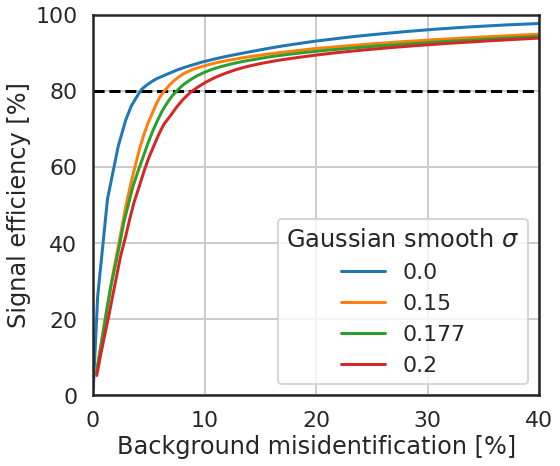

In [10]:
plt.figure(figsize=(8,7))
plt.xlim(0,40)
plt.ylim(0,100)
plt.xlabel('Background misidentification [%]')
plt.ylabel('Signal efficiency [%]')

bb0n_hist_d = {}
u238_hist_d = {}

df = pd.DataFrame(columns=['dnn_f', 'bkg_misID_85', 'dnn_cut_value_85', 
                           'bkg_misID_80', 'dnn_cut_value_80', 
                           'bkg_misID_75', 'dnn_cut_value_75']) 
df = df.set_index('dnn_f')

for smooth_f in [0., 0.15, 0.177, 0.2, ]:
# for smooth_f in [0.,  ]:
    SignalEfficiency = []
    BackgroundMisID_U238 = []
#     BackgroundMisID_Th232 = []

    print(f"Smoothing factor {smooth_f}")
    bb0n_events_mod = truncated_smooth(np.copy(bb0n_events), smooth_f)
    # th232_events_mod = smooth(th232_events, smooth_f)
    u238_events_mod = truncated_smooth(np.copy(u238_events), smooth_f)

#     bb0n_events_mod = distort_pdf(bb0n_events, 200, 0, 1)
#     u238_events_mod = distort_pdf(u238_events, 200, 1.0, smooth_f)
    
    bb0n_hist_d[smooth_f] = np.histogram(bb0n_events_mod, bins=np.linspace(0,1,100))
    u238_hist_d[smooth_f] = np.histogram(u238_events_mod, bins=np.linspace(0,1,100))

    DNNVals = np.arange(0,1,0.02)
    for x in DNNVals: 
        bb0n_dnn_cut = np.where(bb0n_events_mod > x)
    #     th232_dnn_cut = np.where(th232_events_mod > x)
        u238_dnn_cut = np.where(u238_events_mod > x)

        signal = len(bb0n_events_mod[bb0n_dnn_cut]) / len(bb0n_events_mod)
    #     th232_bkg = len(th232_events_mod[th232_dnn_cut]) / len(th232_events_mod)
        u238_bkg = len(u238_events_mod[u238_dnn_cut]) / len(u238_events_mod)
        # print('%.2f' % x, '%.3f' % signal, '%.3f' % u238_bkg, '%.3f' % th232_bkg)

        SignalEfficiency.append(signal)
        BackgroundMisID_U238.append(u238_bkg)
    #     BackgroundMisID_Th232.append(th232_bkg)
#         print(f'{x:.3f}\t{signal:.3f}\t{u238_bkg:.3f}')

    SignalEfficiency = np.array(SignalEfficiency)
    BackgroundMisID_U238 = np.array(BackgroundMisID_U238)
    # BackgroundMisID_Th232 = np.array(BackgroundMisID_Th232)
    
    roc_f = interpolate.interp1d(SignalEfficiency, BackgroundMisID_U238)
    print(f'--> Background MisID at 85% Signal Efficiency: {roc_f(0.85)*100:.2f}%')
    signal_f = interpolate.interp1d(SignalEfficiency, DNNVals)
    print(f'--> Corresponding DNNValue: {signal_f(0.85):.3f}')
#     for xxx in np.arange(min(SignalEfficiency), max(SignalEfficiency), 0.02):
#         print(xxx, signal_f(xxx))
    
    tmp_dict = {'dnn_f':smooth_f}
    for k in [0.75, 0.8, 0.85]:
        tmp_dict.update({f'bkg_misID_{int(k*100)}':roc_f(k)*100, f'dnn_cut_value_{int(k*100)}':signal_f(k)})
    df.loc[smooth_f] = tmp_dict
    print(tmp_dict)
#     for k in np.arange(0.65, 0.86, 0.01):
#         print(f"{k*100:.1f}%:", roc_f(k)*100, signal_f(k))
    
    plt.plot(BackgroundMisID_U238*100, SignalEfficiency*100, label=f'{smooth_f}' )

plt.hlines(80, 0, 40, color='black', linestyles='dashed')
plt.grid()
plt.legend(title = r'Gaussian smooth $\sigma$')
plt.savefig(plotdir / "dnn_smoothing_ROCs.png", dpi=200, bbox_inches = "tight", transparent=False, facecolor='white')

display(df)
df.to_csv('dnn_smoothing_results.csv')

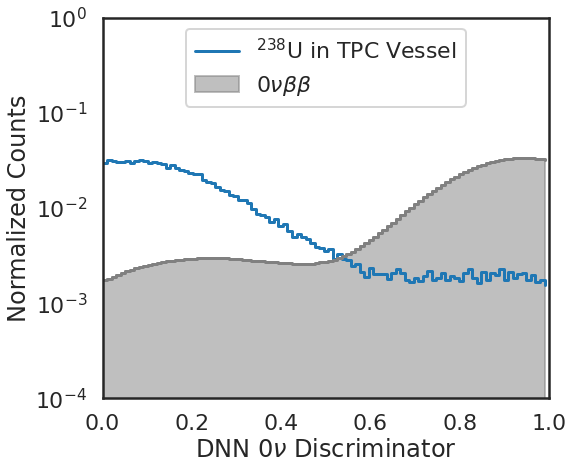

In [11]:
# for smooth_f, hist in 
smooth_f = 0.15

plt.figure(figsize=(8,7))
plt.xlim(0,1)
plt.ylim(1e-4,1e0)
plt.xlabel(r'DNN $0\nu$ Discriminator')
plt.ylabel('Normalized Counts')
plt.yscale('log')

u238_histx = u238_hist_d[smooth_f][1]
u238_hist = u238_hist_d[smooth_f][0]
plt.step(x=u238_histx[:-1], 
         y=u238_hist/np.sum(u238_hist), 
         where='post', 
         label='${}^{238} \mathrm{U}$ in TPC Vessel')

# plt.step(x=th232_histx[:-1], 
#          y=th232_hist/np.sum(th232_hist), 
#          where='post', 
#          ls='--', 
#          label='${}^{232} \mathrm{Th}$ in TPC Vessel')

bb0n_histx = bb0n_hist_d[smooth_f][1]
bb0n_hist = bb0n_hist_d[smooth_f][0]
plt.step(x=bb0n_histx[:-1], 
         y=bb0n_hist/np.sum(bb0n_hist), 
         ls='-', 
         color='grey', 
         where='post', 
         label='', 
         zorder=2)

plt.fill_between(x=bb0n_histx[:-1], 
                y1=bb0n_hist/np.sum(bb0n_hist), 
                alpha=0.5, 
                color='grey', 
                step='post', 
                label=r'$0 \nu\beta\beta$',
                zorder=1)

plt.legend(loc='upper center')
# plt.yticks(fontsize=14)
# plt.xticks(fontsize=14)
plt.savefig(plotdir / f'DNN_distributions_{smooth_f}.png', bbox_inches = "tight", 
                transparent=False, facecolor='white', dpi=200)
plt.show()

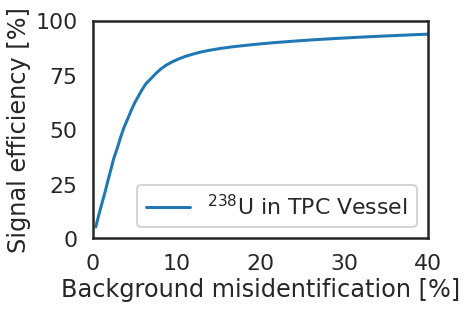

In [12]:
plt.figure()
plt.xlim(0,40)
plt.ylim(0,100)
plt.xlabel('Background misidentification [%]')
plt.ylabel('Signal efficiency [%]')

plt.plot(BackgroundMisID_U238*100, SignalEfficiency*100, 
         color=colors[0], 
         label='${}^{238} \mathrm{U}$ in TPC Vessel' )

# plt.plot(BackgroundMisID_Th232*100, SignalEfficiency*100, 
#          color=colors[1], 
#          ls='--', 
#          label='${}^{232} \mathrm{Th}$ in TPC Vessel')
         
plt.legend(loc='lower right')
plt.show()

In [13]:
rng = np.random.default_rng()
rng.random(size=10)

array([0.05536169, 0.47132518, 0.32204919, 0.37244638, 0.33035694,
       0.64634759, 0.90069608, 0.65530266, 0.34270419, 0.11626276])

len: 49132


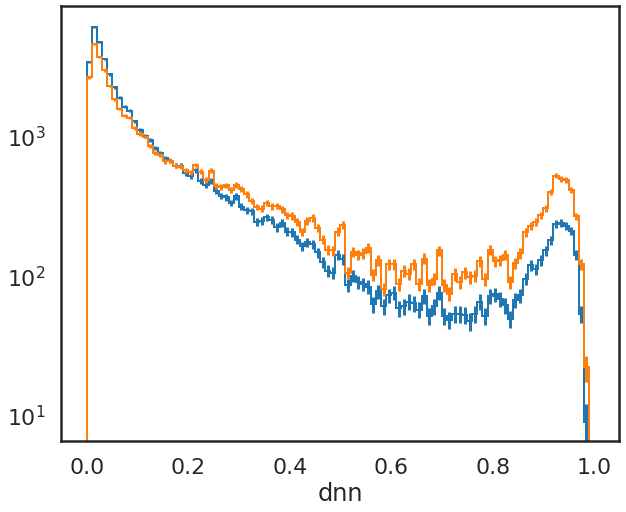

In [14]:
n_bins = 100
h = Hist.new.Regular(n_bins, 0, 1, name="dnn", underflow=False, overflow=False).Double()
h.fill(u238_events)

h_mod = Hist.new.Regular(n_bins, 0, 1, name="dnn", underflow=False, overflow=False).Double()
m = 1.
q = (2-m)/2.
d = distort_pdf(u238_events, n_bins, m, q)
h_mod.fill(d)
print(f"len: {len(d)}")
# h_mod[:] = d

fig, ax = plt.subplots(figsize=(10,8))
h.plot1d(ax=ax)
h_mod.plot1d(ax=ax)
plt.yscale('log')
plt.show()
